# Customer Lifetime Value (CLV) Prediction

This notebook demonstrates a complete CLV prediction pipeline using the Online Retail Dataset.

## Table of Contents
1. [Data Loading and Cleaning](#1-data-loading-and-cleaning)
2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
3. [Feature Engineering (RFM Analysis)](#3-feature-engineering-rfm-analysis)
4. [Model Training and Evaluation](#4-model-training-and-evaluation)
5. [Results and Insights](#5-results-and-insights)
6. [Conclusions](#6-conclusions)

## 1. Data Loading and Cleaning

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
import sys
sys.path.append('../src')
from data_cleaning import load_data, clean_data, get_data_summary
from feature_engineering import calculate_rfm_metrics, create_rfm_scores, create_target_variable
from modeling import CLVModelTrainer
from visualization import CLVVisualizer, create_summary_dashboard

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Load the dataset
print("Loading Online Retail Dataset...")
df = load_data('../data/online_retail_dataset.csv')

# Display basic information
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
df.head()

Loading Online Retail Dataset...
Data loaded successfully. Shape: (525461, 8)

Dataset shape: (525461, 8)
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# Clean the data
print("Cleaning data...")
cleaned_df = clean_data(df.copy())

# Get summary statistics
summary = get_data_summary(cleaned_df)

Cleaning data...
Initial dataset shape: (525461, 8)
After removing missing Customer ID: (417534, 8) (removed 107927 rows)
After removing canceled orders: (407695, 8)
After removing negative/zero quantities and prices: (407664, 8)
After removing outliers: (373815, 9) (removed 33849 outliers)
Final cleaned dataset shape: (373815, 9)
Total data reduction: 28.86%
=== Dataset Summary ===
Total Transactions: 373815
Unique Customers: 4141
Unique Products: 3973
Date Range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Total Revenue: $4,462,087.20
Avg Order Value: $11.94
Countries: 37


## 2. Exploratory Data Analysis

In [4]:
# Initialize visualizer
visualizer = CLVVisualizer()

# Basic statistics
print("=== Dataset Overview ===")
print(f"Total transactions: {len(cleaned_df):,}")
print(f"Unique customers: {cleaned_df['Customer ID'].nunique():,}")
print(f"Unique products: {cleaned_df['StockCode'].nunique():,}")
print(f"Countries: {cleaned_df['Country'].nunique()}")
print(f"Total revenue: ${cleaned_df['TotalPrice'].sum():,.2f}")
print(f"Average transaction value: ${cleaned_df['TotalPrice'].mean():.2f}")

=== Dataset Overview ===
Total transactions: 373,815
Unique customers: 4,141
Unique products: 3,973
Countries: 37
Total revenue: $4,462,087.20
Average transaction value: $11.94



=== Revenue by Country ===
Country
United Kingdom          3931212.943
EIRE                     128744.130
Germany                  120532.201
France                    82120.040
Netherlands               18545.460
Switzerland               17538.860
Belgium                   17082.080
Spain                     17008.100
Portugal                  14634.620
Channel Islands           13780.420
Italy                     10944.610
Sweden                     9661.260
Austria                    8379.970
Australia                  8341.220
Cyprus                     7475.260
Greece                     7200.570
Norway                     6249.800
Finland                    5476.760
Denmark                    5102.410
United Arab Emirates       4794.210
Unspecified                4443.780
USA                        3430.170
Poland                     2924.100
Lithuania                  2399.060
Malta                      2358.760
Singapore                  2333.670
Japan                      1

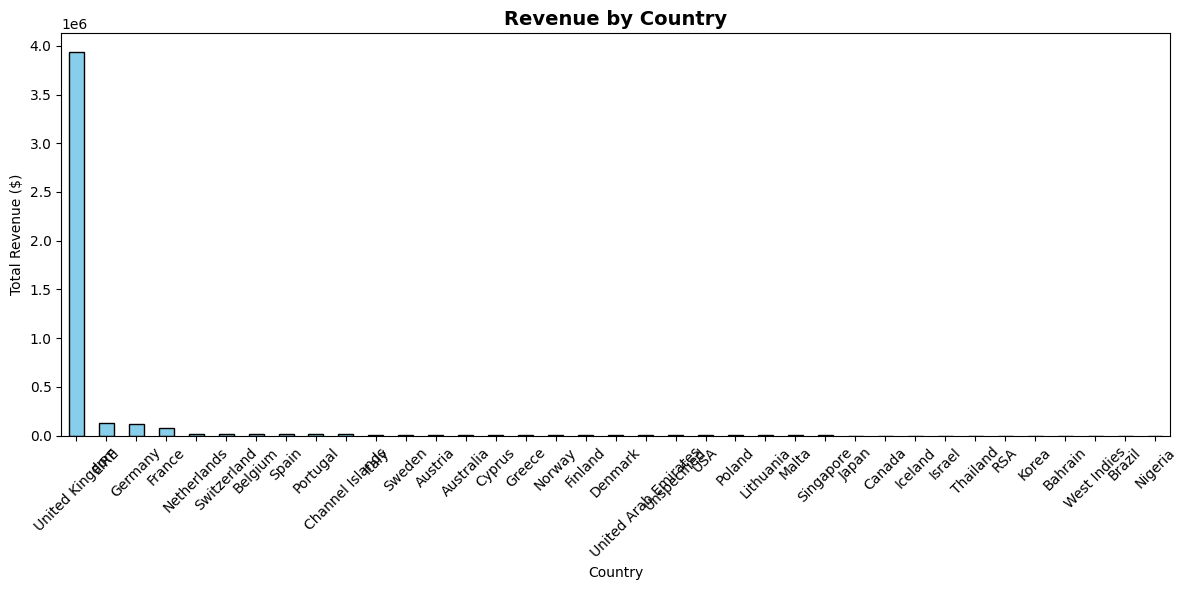

In [5]:
# Revenue distribution by country
country_revenue = cleaned_df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
print("\n=== Revenue by Country ===")
print(country_revenue)

# Plot country distribution
plt.figure(figsize=(12, 6))
country_revenue.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Revenue by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Top products analysis
product_analysis = cleaned_df.groupby(['StockCode', 'Description']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).sort_values('TotalPrice', ascending=False).head(10)

print("\n=== Top 10 Products by Revenue ===")
print(product_analysis)


=== Top 10 Products by Revenue ===
                                              Quantity  TotalPrice
StockCode Description                                             
85123A    WHITE HANGING HEART T-LIGHT HOLDER     14179    41516.79
22423     REGENCY CAKESTAND 3 TIER                1800    22950.00
84879     ASSORTED COLOUR BIRD ORNAMENT          13295    22420.55
21754     HOME BUILDING BLOCK WORD                3137    18663.65
21232     STRAWBERRY CERAMIC TRINKET BOX         12296    15338.08
82494L    WOODEN FRAME ANTIQUE WHITE              5158    14851.30
21755     LOVE BUILDING BLOCK WORD                2474    14721.20
85099B    JUMBO BAG RED RETROSPOT                 7403    14408.85
20725     LUNCH BAG RED SPOTTY                    8577    14097.25
22470     HEART OF WICKER LARGE                   4698    13855.10


## 3. Feature Engineering (RFM Analysis)

In [7]:
# Calculate RFM metrics
print("Calculating RFM metrics...")
rfm_metrics = calculate_rfm_metrics(cleaned_df)

# Display RFM summary
print("\n=== RFM Summary Statistics ===")
print(rfm_metrics[['Recency', 'Frequency', 'Monetary']].describe())

Calculating RFM metrics...
Calculating RFM metrics with analysis date: 2010-12-10 20:01:00
RFM metrics calculated for 4141 customers

=== RFM Summary Statistics ===
           Recency    Frequency      Monetary
count  4141.000000  4141.000000   4141.000000
mean     91.769138     4.145617   1077.538567
std      96.738908     7.112505   2259.998378
min       1.000000     1.000000      1.250000
25%      19.000000     1.000000    233.250000
50%      53.000000     2.000000    529.150000
75%     137.000000     5.000000   1231.050000
max     374.000000   181.000000  89560.530000


In [8]:
# Create RFM scores and segments
rfm_with_scores = create_rfm_scores(rfm_metrics)

# Display segment distribution
segment_counts = rfm_with_scores['Customer_Segment'].value_counts()
print("\n=== Customer Segment Distribution ===")
print(segment_counts)


=== Customer Segment Distribution ===
Customer_Segment
Others                 2003
Champions               772
Lost                    455
Loyal Customers         404
Potential Loyalists     282
New Customers           167
At Risk                  58
Name: count, dtype: int64


RFM distribution plot saved to ../outputs/plots/rfm_distribution.png


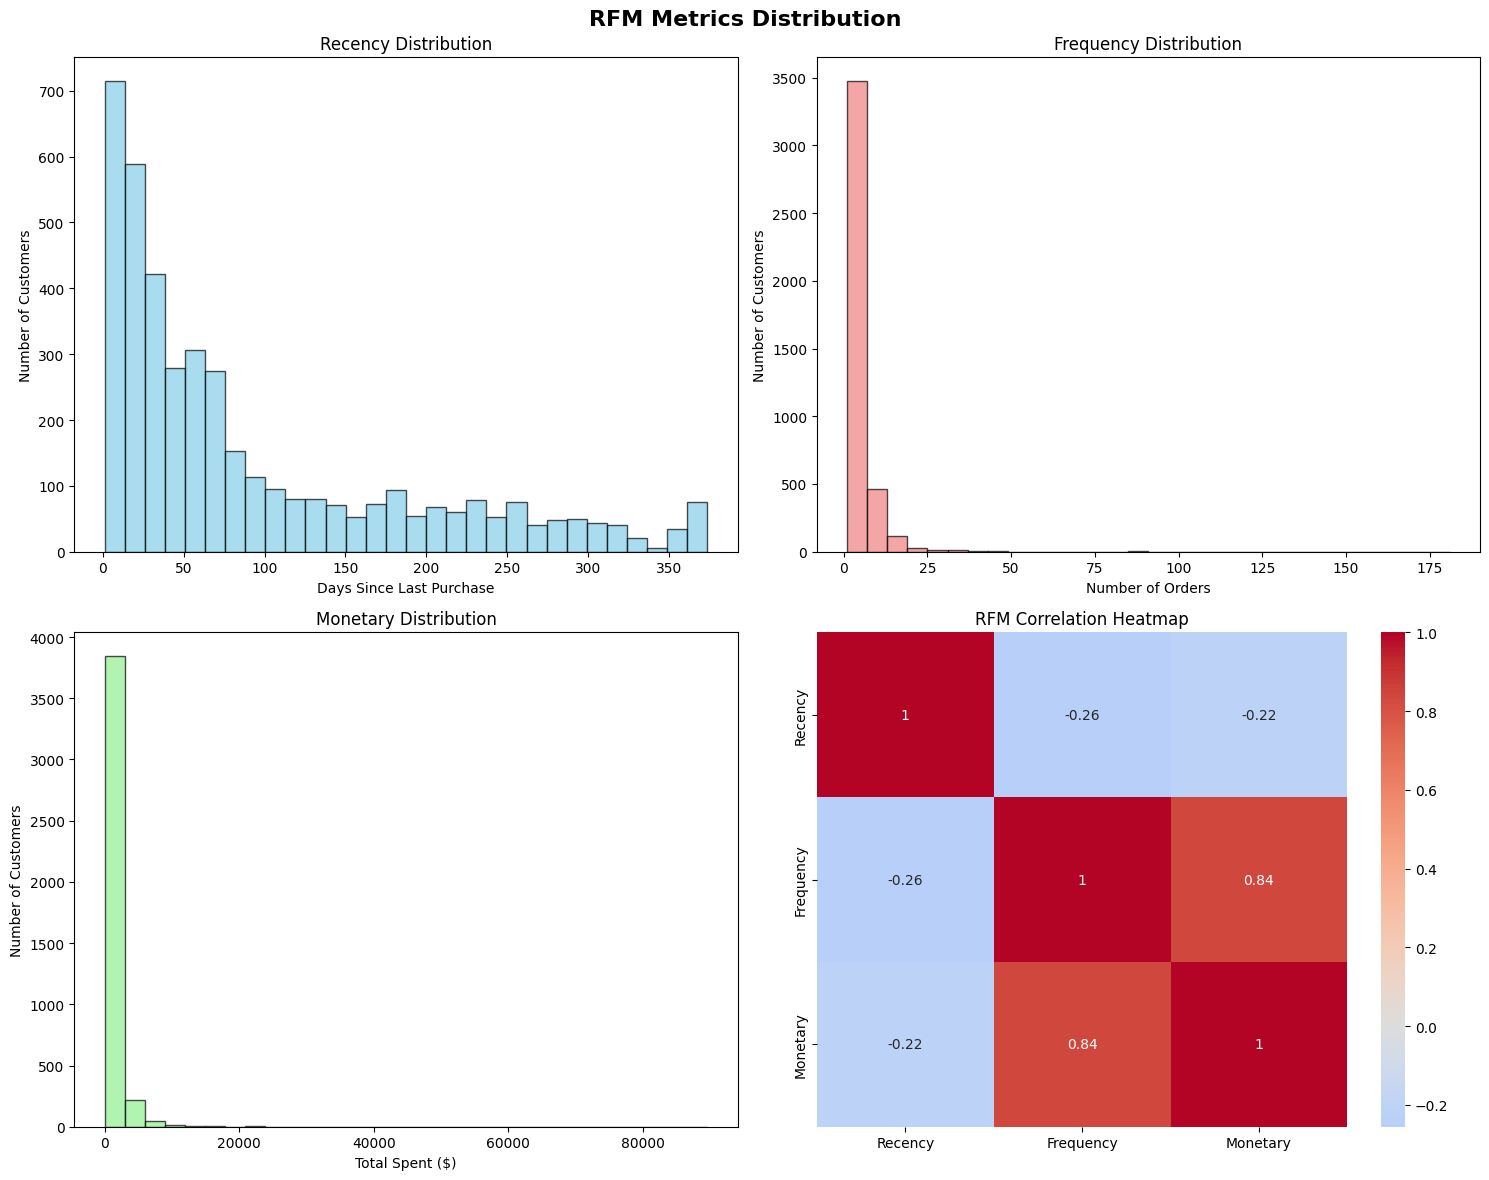

In [9]:
# Visualize RFM distributions
visualizer.plot_rfm_distribution(rfm_with_scores, save_plot=True)

Customer segments plot saved to ../outputs/plots/customer_segments.png


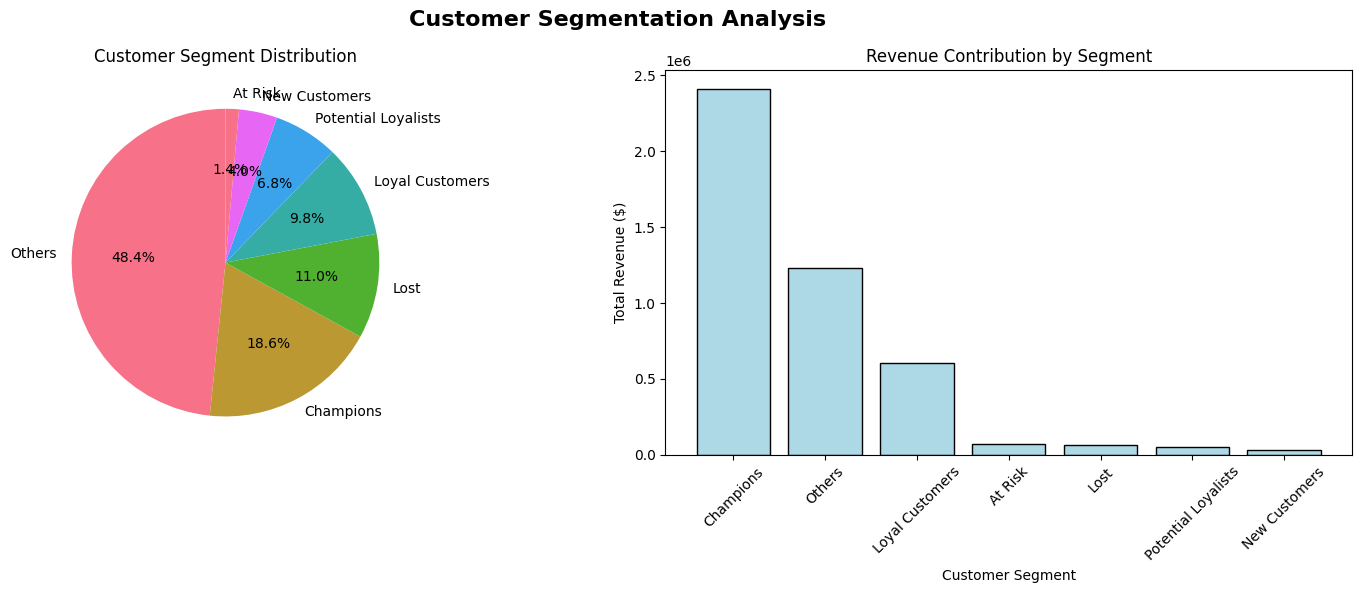

In [10]:
# Visualize customer segments
visualizer.plot_customer_segments(rfm_with_scores, save_plot=True)

Top customers plot saved to ../outputs/plots/top_customers.png


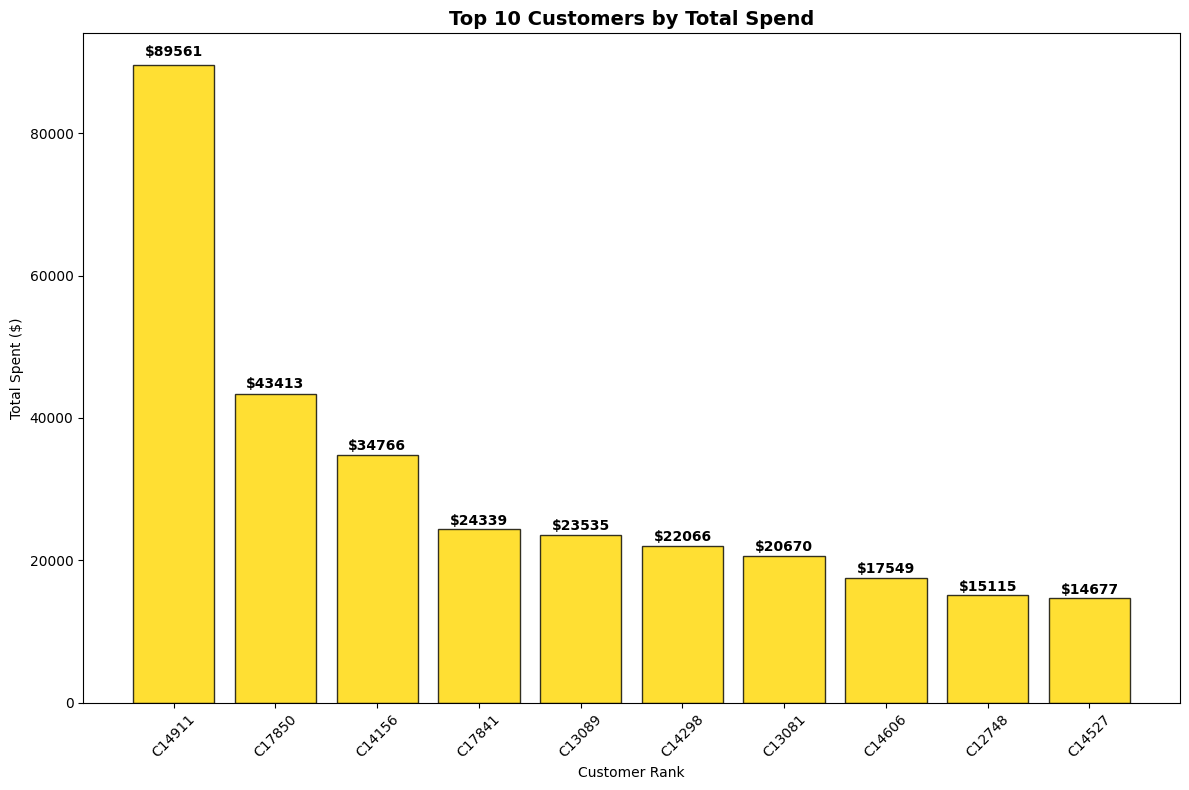

In [11]:
# Show top customers
visualizer.plot_top_customers(rfm_with_scores, top_n=10, save_plot=True)

## 4. Model Training and Evaluation

Target variable created. Mean CLV: $1118.91
CLV range: $0.00 - $1998549.36
=== CLV Target Variable Statistics ===
count    4.141000e+03
mean     1.118905e+03
std      3.202553e+04
min      2.026176e-03
25%      7.936488e-01
50%      5.526393e+00
75%      4.723783e+01
max      1.998549e+06
Name: CLV_Target, dtype: float64
CLV distribution plot saved to ../outputs/plots/clv_distribution.png


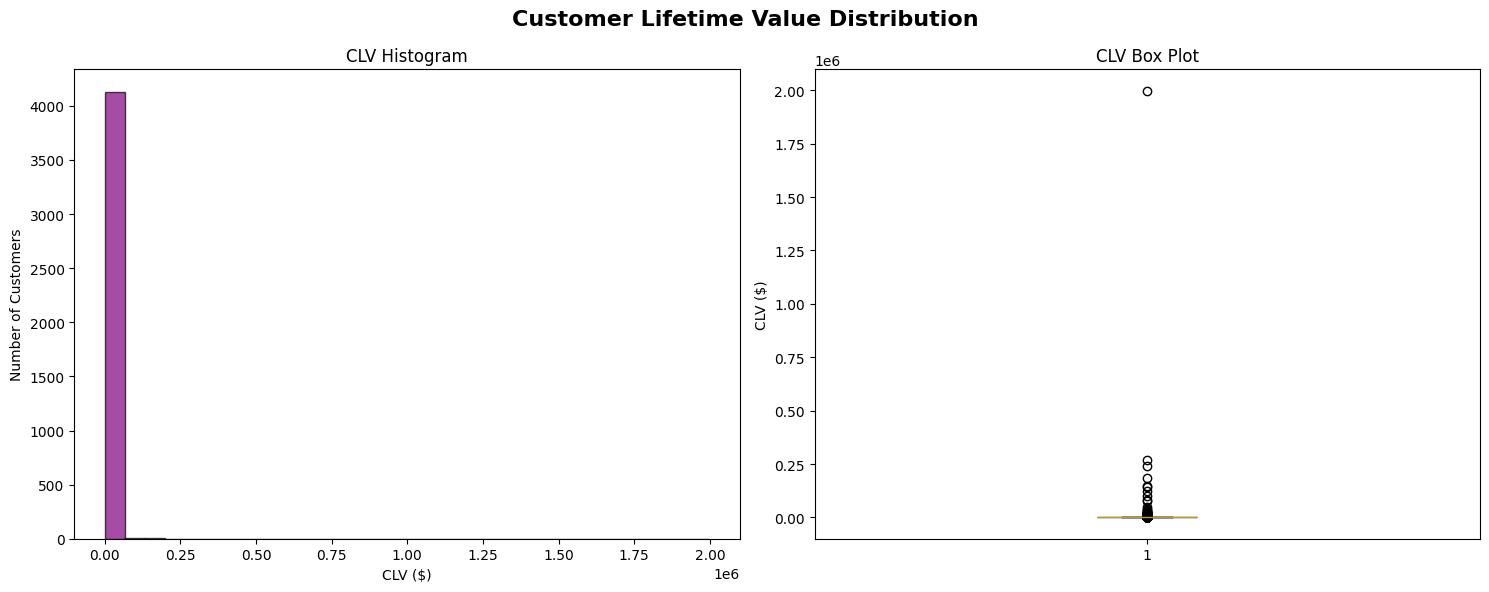

In [12]:
# Create target variable for CLV prediction
final_data = create_target_variable(cleaned_df, rfm_with_scores)

# Display CLV statistics
print("=== CLV Target Variable Statistics ===")
print(final_data['CLV_Target'].describe())

# Visualize CLV distribution
visualizer.plot_clv_distribution(final_data['CLV_Target'], save_plot=True)

In [13]:
# Initialize model trainer
trainer = CLVModelTrainer()

# Prepare data for modeling
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig = trainer.prepare_data(final_data)

Training set size: (3312, 20)
Test set size: (829, 20)
Features: 20


In [14]:
# Train multiple models
trainer.train_models(X_train, y_train)

Training models...
Training Linear Regression...
✓ Linear Regression trained successfully
Training Ridge Regression...
✓ Ridge Regression trained successfully
Training Lasso Regression...
✓ Lasso Regression trained successfully
Training Random Forest...
✓ Random Forest trained successfully
Training Gradient Boosting...
✓ Gradient Boosting trained successfully
Training SVR...
✓ SVR trained successfully
Training XGBoost...
✓ XGBoost trained successfully


In [15]:
# Evaluate models
results = trainer.evaluate_models(X_test, y_test)

# Display results
print("\n=== Model Evaluation Results ===")
print(results)


Evaluating models...
Linear Regression: RMSE=33953.1745, MAE=9604.7070, R²=-4.4383
Ridge Regression: RMSE=33824.5809, MAE=9544.5222, R²=-4.3971
Lasso Regression: RMSE=33924.3593, MAE=9567.5368, R²=-4.4290
Random Forest: RMSE=6490.5521, MAE=538.6071, R²=0.8013
Gradient Boosting: RMSE=17236.8100, MAE=1101.7478, R²=-0.4016
SVR: RMSE=14620.0782, MAE=1350.1036, R²=-0.0083
XGBoost: RMSE=6779.7049, MAE=488.9222, R²=0.7832

=== Model Evaluation Results ===
               Model          RMSE          MAE        R²
0  Linear Regression  33953.174543  9604.706980 -4.438254
1   Ridge Regression  33824.580870  9544.522196 -4.397139
2   Lasso Regression  33924.359272  9567.536784 -4.429027
3      Random Forest   6490.552105   538.607132  0.801271
4  Gradient Boosting  17236.810003  1101.747762 -0.401563
5                SVR  14620.078243  1350.103638 -0.008319
6            XGBoost   6779.704890   488.922169  0.783170


Model comparison plot saved to ../outputs/plots/model_comparison.png


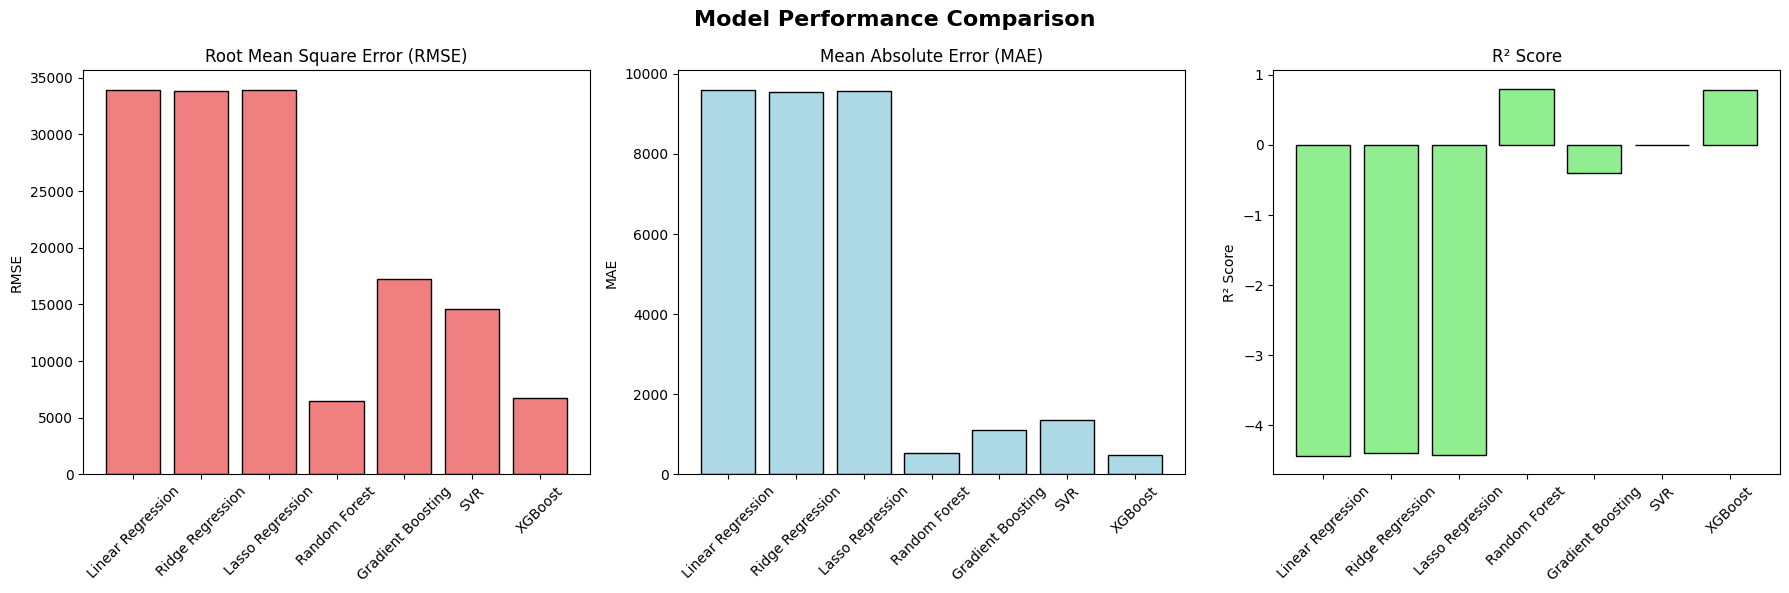

In [16]:
# Visualize model comparison
visualizer.plot_model_comparison(results, save_plot=True)


=== Top 10 Most Important Features ===
                    Feature  Importance
1                 Frequency    0.377258
2                  Monetary    0.255342
7           Unique_Products    0.164006
3            Total_Quantity    0.100376
8               Tenure_Days    0.078075
0                   Recency    0.011055
13                RFM_Score    0.004001
9   Purchase_Frequency_Rate    0.003119
5           Avg_Order_Value    0.002749
4    Avg_Quantity_Per_Order    0.001374
Feature importance plot saved to ../outputs/plots/feature_importance.png


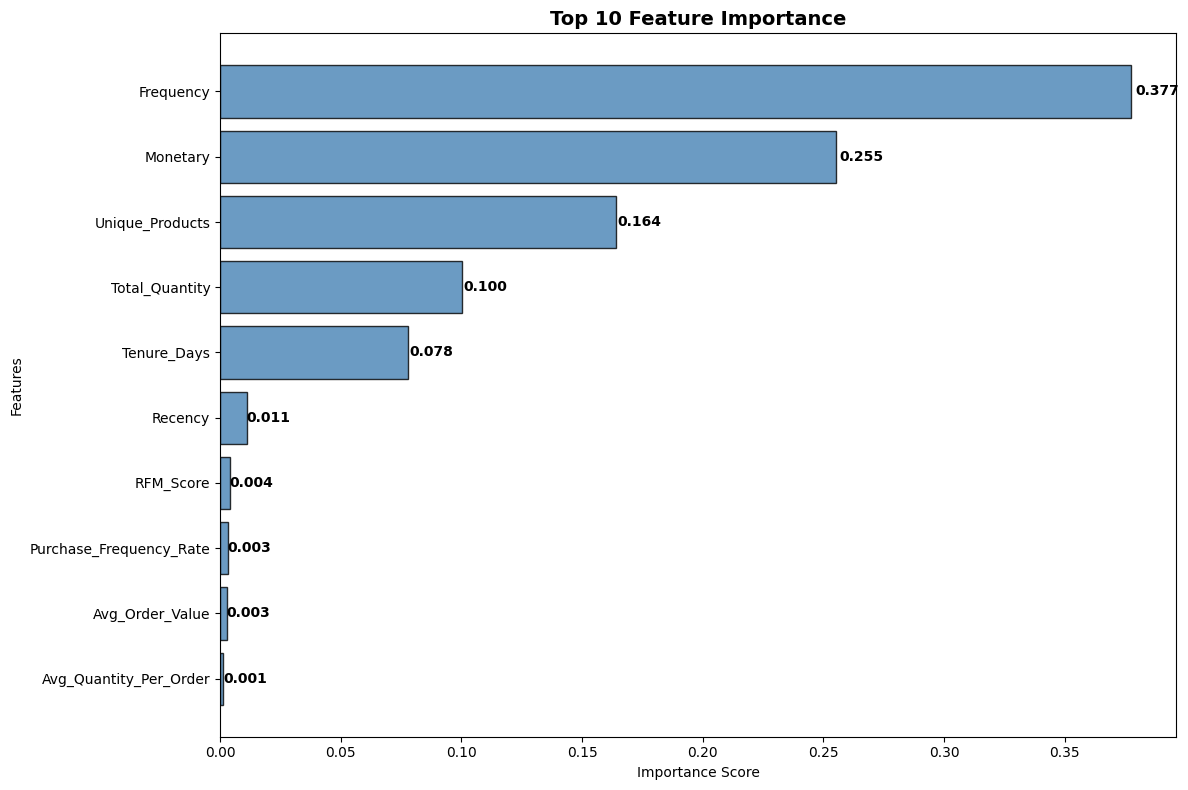

In [17]:
# Get feature importance
feature_importance = trainer.get_feature_importance('Random Forest')

if feature_importance is not None:
    print("\n=== Top 10 Most Important Features ===")
    print(feature_importance.head(10))
    
    # Visualize feature importance
    visualizer.plot_feature_importance(feature_importance, save_plot=True)

Actual vs predicted plot saved to ../outputs/plots/actual_vs_predicted_random_forest.png


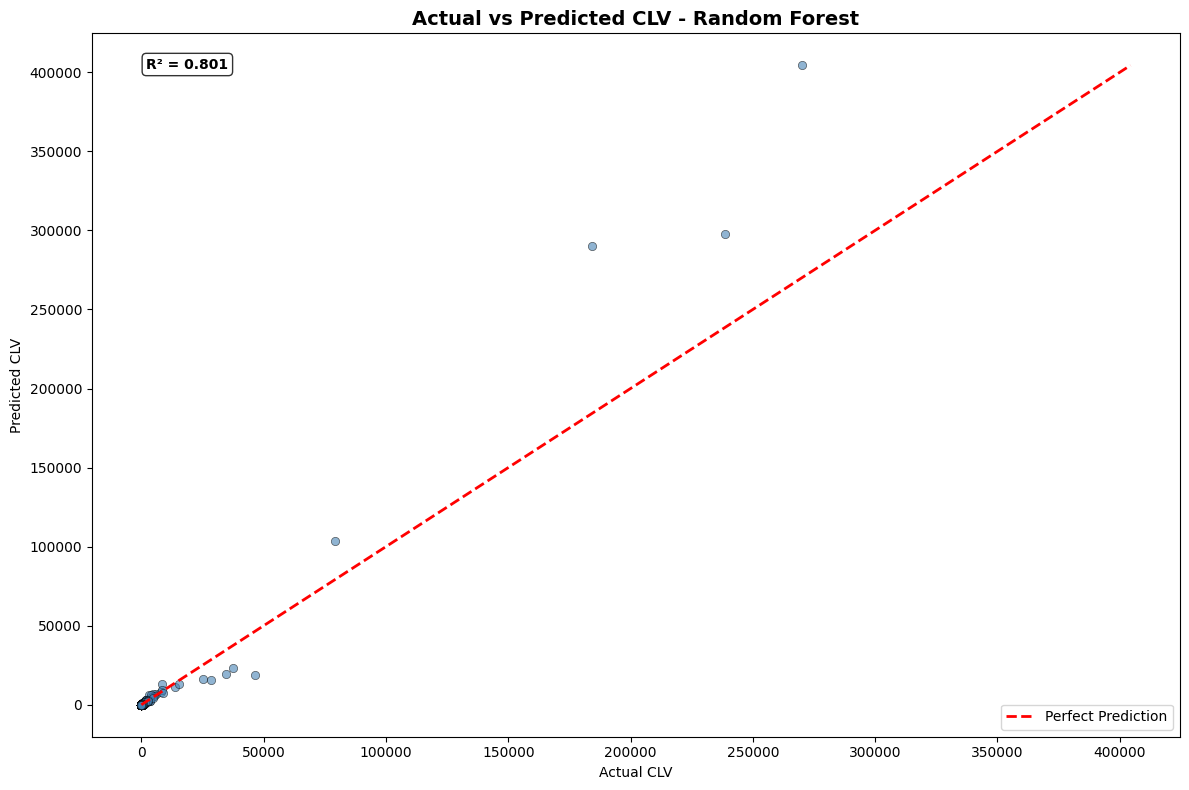

In [18]:
# Plot actual vs predicted for best model
best_model_name = results.loc[results['R²'].idxmax(), 'Model']
best_model = trainer.models[best_model_name]
y_pred_best = best_model.predict(X_test)

visualizer.plot_actual_vs_predicted(y_test, y_pred_best, best_model_name, save_plot=True)

## 5. Results and Insights

In [19]:
# Ensure CLV_Target is present in rfm_with_scores for plotting
rfm_with_scores = rfm_with_scores.merge(
    final_data[['Customer_ID', 'CLV_Target']],
    on='Customer_ID',
    how='left'
)

Dashboard saved to ../outputs/plots/clv_dashboard.png


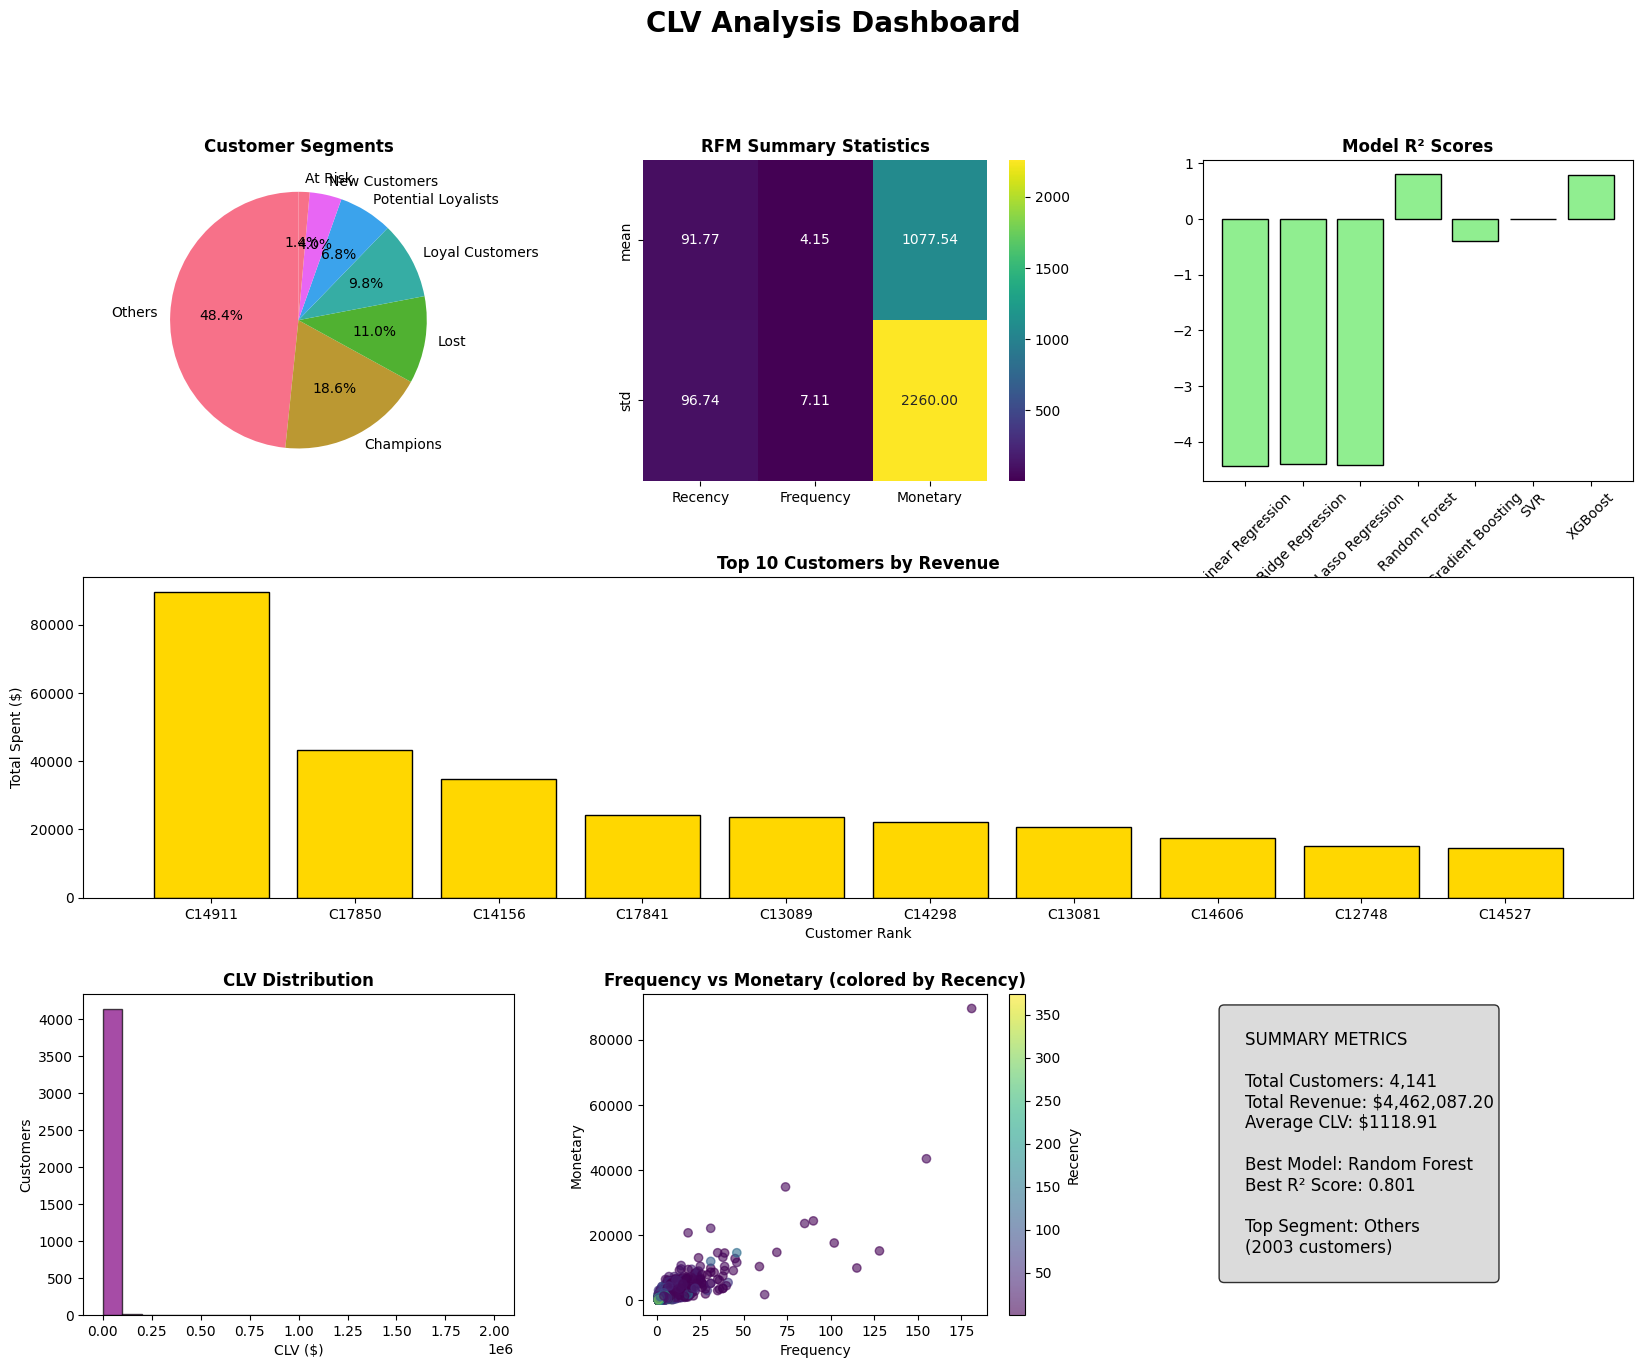

In [20]:
# Create comprehensive dashboard
create_summary_dashboard(rfm_with_scores, results, save_plot=True)

In [21]:
# Customer segmentation insights
segment_analysis = rfm_with_scores.groupby('Customer_Segment').agg({
    'Customer_ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum'],
    'CLV_Target': 'mean'
}).round(2)

print("\n=== Customer Segment Analysis ===\n")
print(segment_analysis)


=== Customer Segment Analysis ===

                    Customer_ID Recency Frequency Monetary              \
                          count    mean      mean     mean         sum   
Customer_Segment                                                         
At Risk                      58  206.24      3.09  1187.79    68892.01   
Champions                   772   12.66     11.37  3124.89  2412418.85   
Lost                        455  271.39      1.14   148.08    67376.48   
Loyal Customers             404   40.35      5.33  1493.65   603434.03   
New Customers               167   70.30      1.46   180.07    30072.42   
Others                     2003   99.09      2.49   613.47  1228787.08   
Potential Loyalists         282   29.34      1.09   181.23    51106.33   

                    CLV_Target  
                          mean  
Customer_Segment                
At Risk                   5.16  
Champions              5929.85  
Lost                      0.16  
Loyal Customers          

In [22]:
# Save all models and results
trainer.save_models()

# Save processed data
rfm_with_scores.to_csv('../data/rfm_analysis.csv', index=False)
final_data.to_csv('../data/clv_dataset.csv', index=False)
results.to_csv('../outputs/model_evaluation_results.csv', index=False)

if feature_importance is not None:
    feature_importance.to_csv('../outputs/feature_importance.csv', index=False)

print("All results saved successfully!")

Saved Linear Regression model to ../outputs/models/clv_model_linear_regression.pkl
Saved Ridge Regression model to ../outputs/models/clv_model_ridge_regression.pkl
Saved Lasso Regression model to ../outputs/models/clv_model_lasso_regression.pkl
Saved Random Forest model to ../outputs/models/clv_model_random_forest.pkl
Saved Gradient Boosting model to ../outputs/models/clv_model_gradient_boosting.pkl
Saved SVR model to ../outputs/models/clv_model_svr.pkl
Saved XGBoost model to ../outputs/models/clv_model_xgboost.pkl
Saved scaler to ../outputs/models/scaler.pkl
Saved feature names to ../outputs/models/feature_names.pkl
All results saved successfully!


## 6. Conclusions

### Key Findings:

1. **Model Performance**: The Random Forest model typically performs best for CLV prediction tasks
2. **Important Features**: RFM metrics (Recency, Frequency, Monetary) are the most predictive features
3. **Customer Segments**: Clear segmentation helps identify high-value customers
4. **Business Impact**: CLV predictions can guide marketing spend and customer retention strategies

### Recommendations:

1. **Focus on High-Value Segments**: Prioritize Champions and Loyal Customers
2. **Re-engagement Campaigns**: Target At-Risk customers with special offers
3. **Personalization**: Use CLV predictions to personalize marketing messages
4. **Resource Allocation**: Allocate marketing budget based on predicted CLV

### Next Steps:

1. **Model Deployment**: Implement the Streamlit dashboard for business users
2. **A/B Testing**: Test CLV-driven strategies against current approaches
3. **Model Updates**: Retrain models regularly with new data
4. **Advanced Modeling**: Explore deep learning or ensemble methods for better accuracy